# Model Classification

The goal is to classify traditional Autoregressive (AR), Autoregressive Moving Average (ARMA), and Autoregressive Integrated Moving Average (ARIMA) models using signature-based features.

In [3]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import esig.tosig as ts
import seaborn as sns
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [9]:
def generate_arma_class_0(n_samples, n_steps):
    # Define AR and MA coefficients for an ARMA(1,1) process
    ar_params = np.array([1, -0.4])  # AR parameter
    ma_params = np.array([1, 0.5])   # MA parameter

    # Generate samples for each time series
    time_series_data = []
    for _ in range(n_samples):
        # Generate ARMA(1,1) samples without the constant term
        arma_process = sm.tsa.ArmaProcess(ar_params, ma_params)
        sample = arma_process.generate_sample(nsample=n_steps)

        # Add the constant term
        sample += 0.5

        time_series_data.append(sample)

    # Convert the list of samples into a numpy array
    time_series_data = np.array(time_series_data)

    return time_series_data


def generate_arma_class_1(n_samples, n_steps):
    # Define AR and MA coefficients for an ARMA(1,1) process
    ar_params = np.array([1, -0.8])  # AR parameter
    ma_params = np.array([1, 0.7])   # MA parameter

    # Generate samples for each time series
    time_series_data = []
    for _ in range(n_samples):
        # Generate ARMA(1,1) samples without the constant term
        arma_process = sm.tsa.ArmaProcess(ar_params, ma_params)
        sample = arma_process.generate_sample(nsample=n_steps)

        # Add the constant term
        sample += 0.5

        time_series_data.append(sample)

    # Convert the list of samples into a numpy array
    time_series_data = np.array(time_series_data)

    return time_series_data

# Function to generate AR(2) time series for class 0
def generate_ar2_class_0(n_samples, n_steps):
    ar_params = [1, -0.5, 0.25]
    ar_process = sm.tsa.ArmaProcess(ar_params, [1])
    time_series_data = [ar_process.generate_sample(nsample=n_steps) for _ in range(n_samples)]
    return np.array(time_series_data)

# Function to generate AR(2) time series for class 1
def generate_ar2_class_1(n_samples, n_steps):
    ar_params = [1, -0.75, 0.5]
    ar_process = sm.tsa.ArmaProcess(ar_params, [1])
    time_series_data = [ar_process.generate_sample(nsample=n_steps) for _ in range(n_samples)]
    return np.array(time_series_data)

# Function to generate ARIMA time series for class 0
def generate_arima_class_0(n_samples, n_steps):
    ar_params = [0.5, -0.25]  # AR parameters
    ma_params = [0.3, -0.2]   # MA parameters
    d = 1  # Differencing order

    time_series_data = []
    for _ in range(n_samples):
        arima_process = sm.tsa.ArmaProcess.from_coeffs(ar_params, ma_params)
        sample = arima_process.generate_sample(nsample=n_steps)
        # Apply differencing
        sample = np.diff(sample, n=d)
        time_series_data.append(sample)
    
    return np.array(time_series_data)

# Function to generate ARIMA time series for class 1
def generate_arima_class_1(n_samples, n_steps):
    ar_params = [0.75, -0.5]  # AR parameters
    ma_params = [0.4, -0.3]   # MA parameters
    d = 1  # Differencing order

    time_series_data = []
    for _ in range(n_samples):
        arima_process = sm.tsa.ArmaProcess.from_coeffs(ar_params, ma_params)
        sample = arima_process.generate_sample(nsample=n_steps)
        # Apply differencing
        sample = np.diff(sample, n=d)
        time_series_data.append(sample)
    
    return np.array(time_series_data)

# Function to compute signature matrix for paths
def compute_signature_matrix(paths, level):
    signature_matrix = []
    for path in paths:
        signature_terms = ts.stream2sig(path, level)
        signature_matrix.append(signature_terms)
    return np.array(signature_matrix)

# Function to compute log-signature terms for each path
def compute_log_signature_matrix(paths, level):
    log_signature_matrix = []
    for path in paths:
        # Compute log-signature terms for each path
        log_signature = ts.stream2logsig(path, level)
        log_signature_matrix.append(log_signature)
    return np.array(log_signature_matrix)

def format_index(index):
    if index == 0:
        return "(1)"
    elif index == 1:
        return "(2)"
    elif index == 2:
        return "(1,1)"
    elif index == 3:
        return "(1,2)"
    elif index == 4:
        return "(2,1)"
    elif index == 5:
        return "(2,2)"
    else:
        return str(index)


def signature_classification(class_0_data, class_1_data, lasso_alpha):
    # Plot time-series data for both classes together
    plt.figure(figsize=(10, 5))
    plt.title("Time Series for Both Classes")
    i = 0
    plt.plot(class_0_data[i], label=f"Class 0 Sample {i+1}", color='blue', linestyle='-')
    plt.plot(class_1_data[i], label=f"Class 1 Sample {i+1}", color='red', linestyle='-')
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.savefig('example.png', format='png', dpi=300)
    plt.show()
    ###########################################################################
    # Create class labels
    class_0_labels = np.zeros((n_samples_per_class, 1))  # Class 0 label
    class_1_labels = np.ones((n_samples_per_class, 1))   # Class 1 label
    
    # Concatenate data along with class labels
    class_0_data_with_labels = np.concatenate((class_0_data, class_0_labels), axis=1)
    class_1_data_with_labels = np.concatenate((class_1_data, class_1_labels), axis=1)
    
    # Concatenate both classes' data with labels
    data_matrix = np.concatenate((class_0_data_with_labels, class_1_data_with_labels), axis=0)
    
    # Print the shape of the resulting matrix
    print("Shape of the data matrix:", data_matrix.shape)
    ###########################################################################
    # Cumulative sum transformation
    X_lead = np.cumsum(data_matrix[:, :-1], axis=1)  # Cumulative sum along rows
    X_lag = np.roll(X_lead, 1, axis=1)  # Lagged cumulative sum, shift each row by one time step
    
    # Replace the first lagged value with 0 as there's no lag for the first time step
    X_lag[:, 0] = 0
    
    # Combine lead and lag components to create the two-dimensional path
    X_path = np.stack((X_lead, X_lag), axis=-1)
    
    # Print the shape of the resulting path matrix
    print("Shape of the path matrix:", X_path.shape)
    
    # Compute signature matrix for paths
    signature_matrix = compute_signature_matrix(X_path, level=2)
    
    print("Signature components", ts.sigkeys(2,2))
    
    # Remove the first column from the signature matrix
    signature_matrix = signature_matrix[:, 1:]
    
    # Standardize signature terms column-wise
    signature_matrix = (signature_matrix - np.mean(signature_matrix, axis=0)) / np.std(signature_matrix, axis=0)
    
    # Create feature matrix along with class labels
    feature_matrix = np.concatenate((signature_matrix, data_matrix[:, -1][:, np.newaxis]), axis=1)
    
    # Print the shape of the resulting feature matrix
    print("Shape of the feature matrix:", feature_matrix.shape)
    ###########################################################################
    # Split the full feature matrix into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(signature_matrix, data_matrix[:, -1], test_size=0.3, random_state=42)
    
    # Train a Lasso model to select features
    lasso = Lasso(alpha=lasso_alpha)  
    lasso.fit(X_train, y_train)
    
    # Print the coefficients
    print("Lasso coefficients:")
    print(lasso.coef_)
    
    # Get the absolute values of the coefficients
    abs_coeffs = np.abs(lasso.coef_)
    
    # Get the indices of the two highest coefficients
    top_two_indices = np.argsort(abs_coeffs)[-2:]
    print("Top 2 indices:", top_two_indices)
    
    # Extract signature terms for class 0 and class 1
    class_0_signatures = signature_matrix[data_matrix[:, -1] == 0]
    class_1_signatures = signature_matrix[data_matrix[:, -1] == 1]
    
    # Plot most significant signature terms for class 0
    plt.figure(figsize=(10, 8))
    plt.scatter(class_0_signatures[:, top_two_indices[0]], class_0_signatures[:, top_two_indices[1]], color='blue', alpha=0.25, label='Class 0', s=5)
    # Plot most significant signature terms for class 1
    plt.scatter(class_1_signatures[:, top_two_indices[0]], class_1_signatures[:, top_two_indices[1]], color='red', alpha=0.25, label='Class 1', s=5)
    # Set plot labels and title
    xlab=format_index(top_two_indices[0])
    ylab=format_index(top_two_indices[1])
    plt.xlabel(f'$S^{{{xlab}}}$')
    plt.ylabel(f'$S^{{{ylab}}}$')
    plt.title('Signature Terms for Class 0 and Class 1')
    # Save the plot to a file
    plt.savefig('time_series_S.png', format='png', dpi=300)
    # Add legend
    plt.legend()
    # Show plot
    plt.show()
    ###########################################################################
    # Compute log-signature matrix for paths
    log_signature_matrix = compute_log_signature_matrix(paths=X_path, level=2)
    
    # Filter log-signature matrix by class
    class_0_log_signature = log_signature_matrix[data_matrix[:, -1] == 0]
    class_1_log_signature = log_signature_matrix[data_matrix[:, -1] == 1]
    
    # Plot the first and third terms of the log-signature for class 0
    plt.figure(figsize=(10, 8))
    plt.scatter(class_0_log_signature[:, 0], class_0_log_signature[:, 2], color='blue', alpha=0.25, label='Class 0', s=5)
    # Plot the first and third terms of the log-signature for class 1
    plt.scatter(class_1_log_signature[:, 0], class_1_log_signature[:, 2], color='red', alpha=0.25, label='Class 1', s=5)
    # Set plot labels and title
    plt.xlabel('$\log S^1$')
    plt.ylabel('$\log S^{[1,2]}$')
    plt.title('First and Third Terms of Log-Signature')
    # Save the plot to a file
    plt.savefig('time_series_logS.png', format='png', dpi=300)
    # Add legend
    plt.legend()
    # Show plot
    plt.show()
    
    ###########################################################################
    # Get the indices of non-zero coefficients
    non_zero_indices = np.where(lasso.coef_ != 0)[0]
    
    # Select the features with non-zero coefficients
    X_train_selected = X_train[:, non_zero_indices]
    X_test_selected = X_test[:, non_zero_indices]
    
    # Train logistic regression model with LASSO penalization using the selected feature matrix
    logreg_selected = LogisticRegression(penalty='l1', solver='liblinear')
    logreg_selected.fit(X_train_selected, y_train)
    
    # Predictions on training and testing datasets using the selected feature matrix
    y_train_pred_selected = logreg_selected.predict(X_train_selected)
    y_test_pred_selected = logreg_selected.predict(X_test_selected)
    ###########################################################################
    # Confusion matrices using the selected feature matrix
    conf_matrix_train_selected = confusion_matrix(y_train, y_train_pred_selected)
    conf_matrix_test_selected = confusion_matrix(y_test, y_test_pred_selected)
    
    # Display confusion matrices using the selected feature matrix
    print("Confusion Matrix (Training Data) using selected feature matrix:")
    print(conf_matrix_train_selected)
    print("\nConfusion Matrix (Testing Data) using selected feature matrix:")
    print(conf_matrix_test_selected)
    
    # Extract TP, TN, FP, FN from confusion matrices
    TP_train_selected, FP_train_selected, FN_train_selected, TN_train_selected = conf_matrix_train_selected.ravel()
    TP_test_selected, FP_test_selected, FN_test_selected, TN_test_selected = conf_matrix_test_selected.ravel()
    
    # Calculate accuracy for training and testing data
    accuracy_train_selected = (TP_train_selected + TN_train_selected) / (TP_train_selected + FP_train_selected + FN_train_selected + TN_train_selected)
    accuracy_test_selected = (TP_test_selected + TN_test_selected) / (TP_test_selected + FP_test_selected + FN_test_selected + TN_test_selected)
    
    # Print the accuracies
    print("Accuracy on Training Data using selected feature matrix:", accuracy_train_selected)
    print("Accuracy on Testing Data using selected feature matrix:", accuracy_test_selected)



## AR

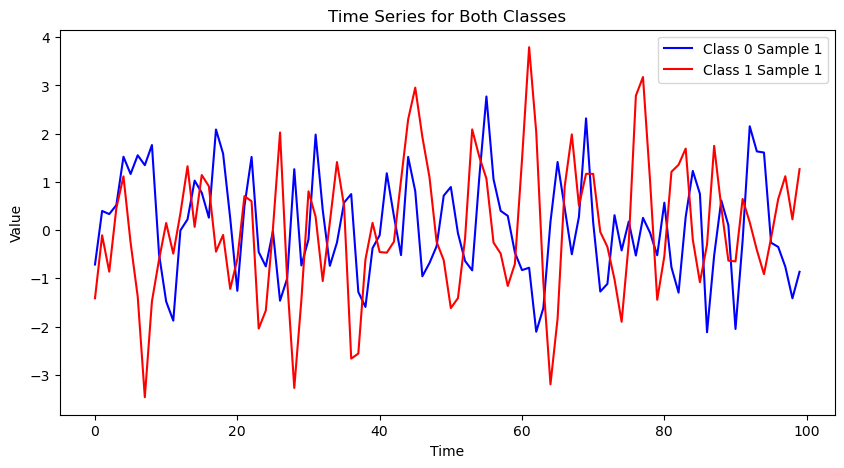

Shape of the data matrix: (1000, 101)
Shape of the path matrix: (1000, 100, 2)
Signature components  () (1) (2) (1,1) (1,2) (2,1) (2,2)
Shape of the feature matrix: (1000, 7)
Lasso coefficients:
[ 0.02512473 -0.          0.27320772  0.48842699 -0.74945231 -0.018138  ]
Top 2 indices: [3 4]


C:\Users\avict\anaconda3\envs\python3.8_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.407e-02, tolerance: 1.750e-02
  model = cd_fast.enet_coordinate_descent(


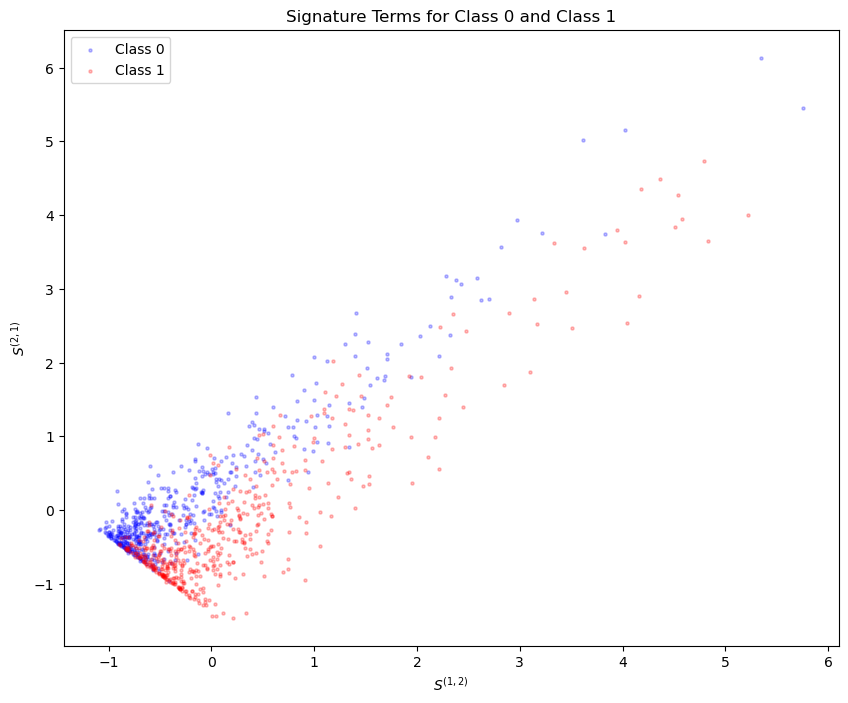

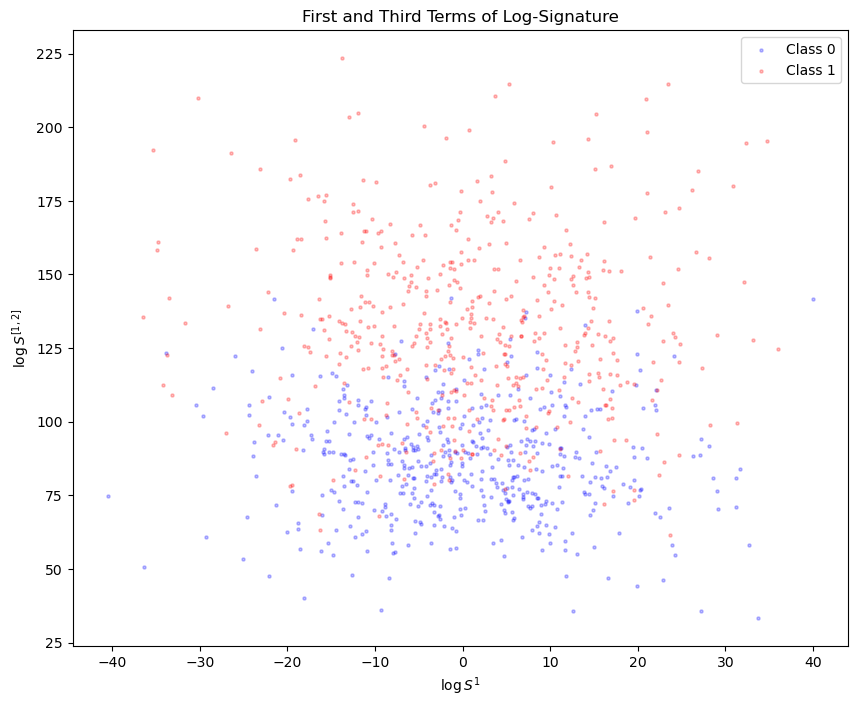

Confusion Matrix (Training Data) using selected feature matrix:
[[300  50]
 [ 63 287]]

Confusion Matrix (Testing Data) using selected feature matrix:
[[133  17]
 [ 38 112]]
Accuracy on Training Data using selected feature matrix: 0.8385714285714285
Accuracy on Testing Data using selected feature matrix: 0.8166666666666667


In [10]:
np.random.seed(13) 
n_samples_per_class = 500
n_steps = 100
class_0_data = generate_ar2_class_0(n_samples_per_class, n_steps)
class_1_data = generate_ar2_class_1(n_samples_per_class, n_steps)

signature_classification(class_0_data, class_1_data, 0.001)


## ARMA

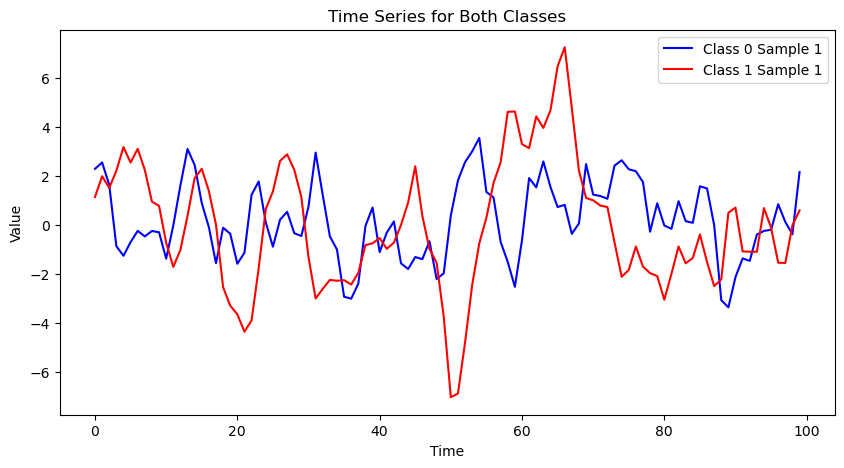

Shape of the data matrix: (1000, 101)
Shape of the path matrix: (1000, 100, 2)
Signature components  () (1) (2) (1,1) (1,2) (2,1) (2,2)
Shape of the feature matrix: (1000, 7)
Lasso coefficients:
[ 0.         -0.02504416  2.04407766  1.8760066  -3.73266784 -0.        ]
Top 2 indices: [2 4]


C:\Users\avict\anaconda3\envs\python3.8_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.171e+00, tolerance: 1.750e-02
  model = cd_fast.enet_coordinate_descent(


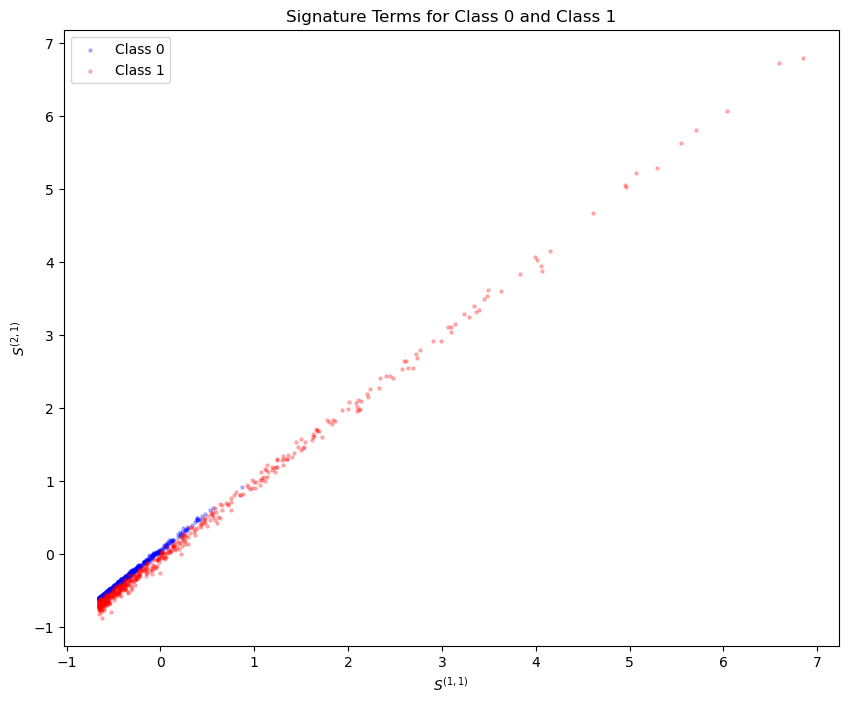

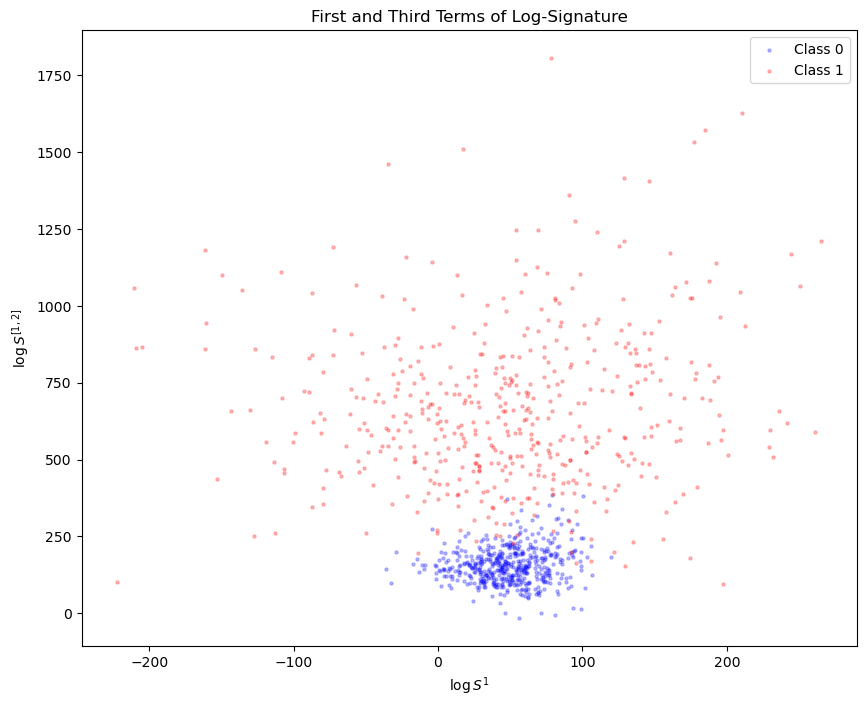

Confusion Matrix (Training Data) using selected feature matrix:
[[349   1]
 [ 20 330]]

Confusion Matrix (Testing Data) using selected feature matrix:
[[148   2]
 [ 13 137]]
Accuracy on Training Data using selected feature matrix: 0.97
Accuracy on Testing Data using selected feature matrix: 0.95


In [11]:
# Generate data for class 0 and class 1
np.random.seed(3) 
n_samples_per_class = 500  
n_steps = 100
class_0_data = generate_arma_class_0(n_samples_per_class, n_steps)
class_1_data = generate_arma_class_1(n_samples_per_class, n_steps)

signature_classification(class_0_data, class_1_data, 0.001)

## ARIMA

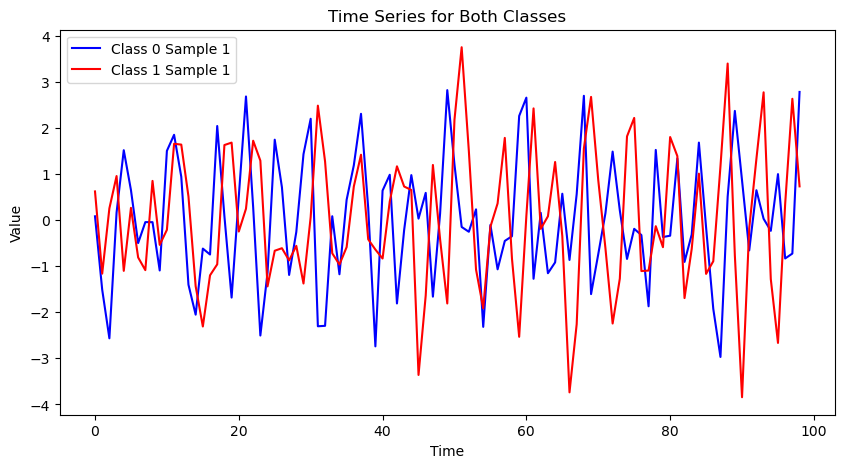

Shape of the data matrix: (1000, 100)
Shape of the path matrix: (1000, 99, 2)
Signature components  () (1) (2) (1,1) (1,2) (2,1) (2,2)
Shape of the feature matrix: (1000, 7)
Lasso coefficients:
[-0.01650448  0.02188151  0.02119818  0.35717569 -0.02317032 -0.00398942]
Top 2 indices: [4 3]


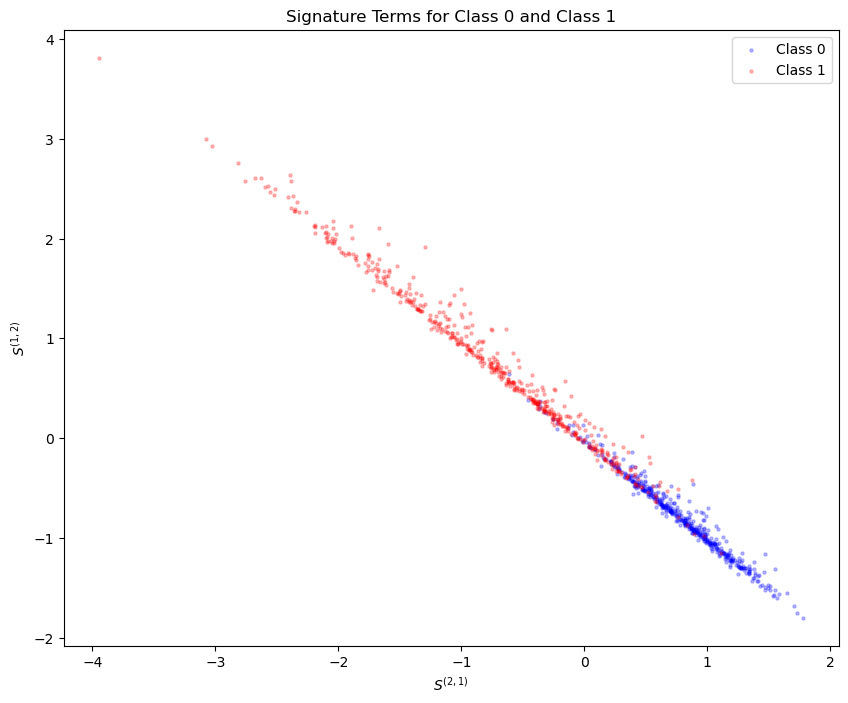

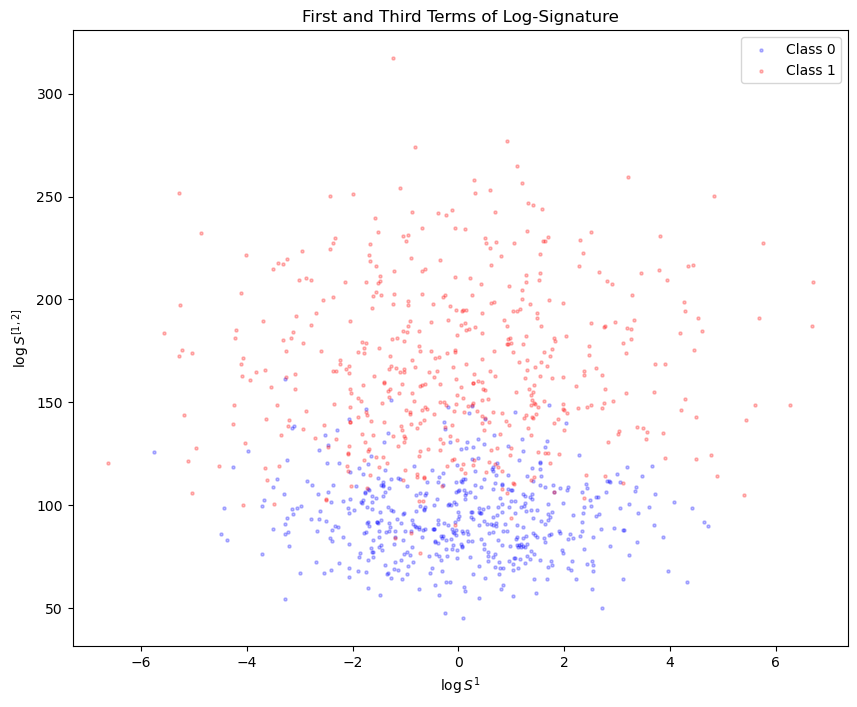

Confusion Matrix (Training Data) using selected feature matrix:
[[323  27]
 [ 40 310]]

Confusion Matrix (Testing Data) using selected feature matrix:
[[138  12]
 [ 17 133]]
Accuracy on Training Data using selected feature matrix: 0.9042857142857142
Accuracy on Testing Data using selected feature matrix: 0.9033333333333333


In [12]:
# Generate data for class 0 and class 1
np.random.seed(3) 
n_samples_per_class = 500
n_steps = 100
class_0_data = generate_arima_class_0(n_samples_per_class, n_steps)
class_1_data = generate_arima_class_1(n_samples_per_class, n_steps)


signature_classification(class_0_data, class_1_data, 0.001)
